## Project_ML_Professional

Botasheva Zhanna

# Обнаружение аварийных твитов с использованием NLP

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install keras-core --upgrade
!pip install -q keras-nlp --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 29.8 MB/s eta 0:00:00


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

Using TensorFlow backend
TensorFlow version: 2.15.0
Keras version: 0.1.7


## О датасете

Данный датасет содержит информацию  о более 10 000 твитов, которые были классифицированы вручную.
Необходимо создать модель машинного обучения, которая предскажет, какие твиты посвящены реальным катастрофам, а какие нет.

Сложность работы заключается в том, что полагаться на ключевые слова, такие как "взрыв" или "пожар" не корректно, так как
не всегда слова человека объявляют о катастрофе.

### Посомтрим на набор данных для обучения и тестирования:

* `id`- уникальный идентификатор для каждого твита
* `text` - текст твита
* `location` - место, откуда был отправлен твит (может быть пустым)
* `keyword` - определенное ключевое слово из твита (может быть пустым)
* `target`- только в файле train.csv это означает, посвящен ли твит реальной катастрофе (1) или нет (0)

In [4]:
train = pd.read_csv("/content/drive/My Drive/ML_Professional/Project/train.csv")
df_test = pd.read_csv("/content/drive/My Drive//ML_Professional/Project/test.csv")

print('Training Set Shape = {}'.format(train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [5]:
train.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

In [6]:
df_test.head()

id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan

In [7]:
train.groupby("target").count()

id  keyword  location  text
target                               
0       4342     4323      2884  4342
1       3271     3229      2196  3271

## Предобработка данных

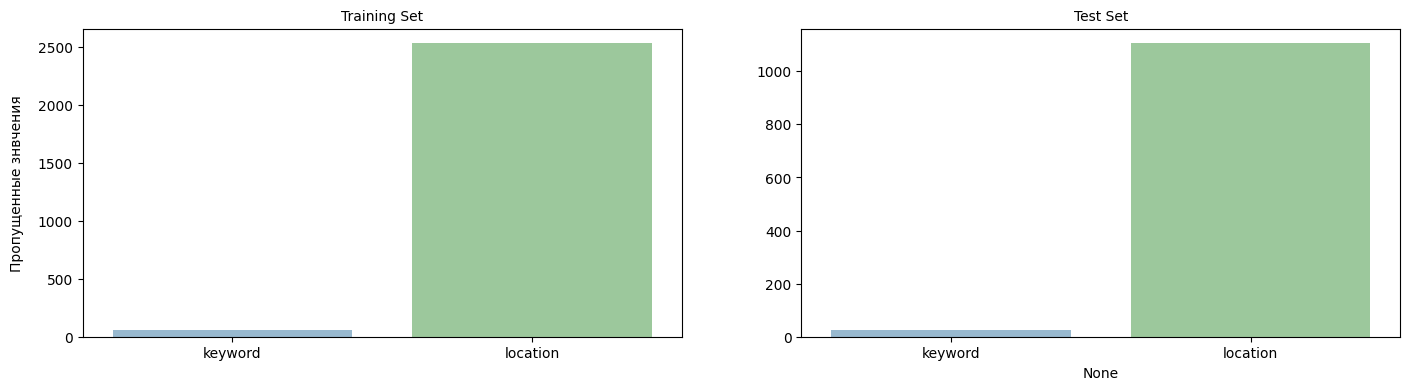

In [8]:
#Пропущенные знвчения

missing_cols = ['keyword', 'location']

fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)

sns.barplot(x=train[missing_cols].isnull().sum().index, y=train[missing_cols].isnull().sum().values, ax=axes[0], palette=["C0", "C2"], alpha=0.5)
sns.barplot(x=df_test[missing_cols].isnull().sum().index, y=df_test[missing_cols].isnull().sum().values, ax=axes[1], palette=["C0", "C2"], alpha=0.5)

axes[0].set_xlabel('')
axes[0].set_ylabel('Пропущенные знвчения', size=10, labelpad=10)
axes[0].tick_params(axis='x', labelsize=10)
axes[0].tick_params(axis='y', labelsize=10)
axes[1].tick_params(axis='x', labelsize=10)
axes[1].tick_params(axis='y', labelsize=10)

axes[0].set_title('Training Set', fontsize=10)
axes[1].set_title('Test Set', fontsize=10)

plt.show()

for df in [train, df_test]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')

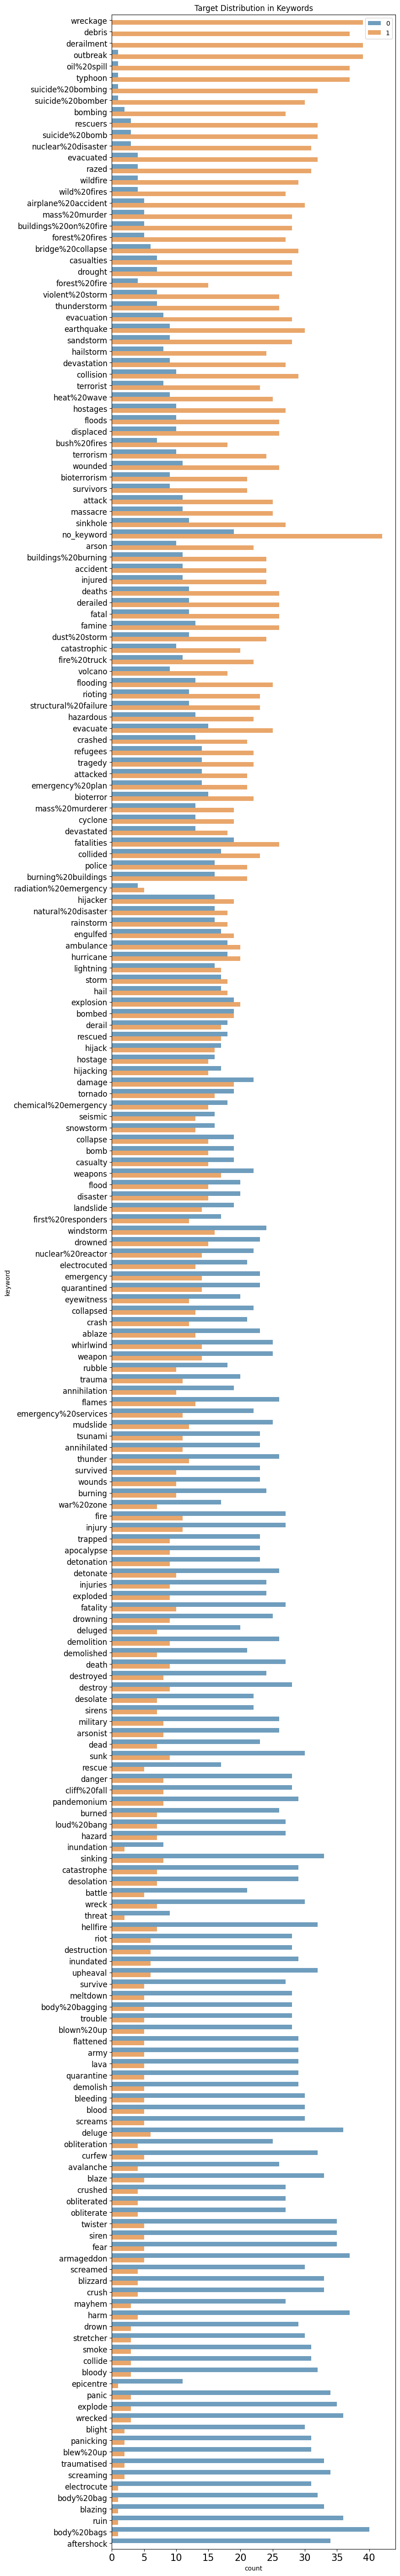

In [9]:
# Распределение ключевого слова в зависимости от посвящен ли твит реальной катастрофе (1) или нет (0)

train['target_mean'] = train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=train.sort_values(by='target_mean', ascending=False)['target'], alpha=0.7)

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

train.drop(columns=['target_mean'], inplace=True)

In [10]:
train.head()

id     keyword     location  \
0   1  no_keyword  no_location   
1   4  no_keyword  no_location   
2   5  no_keyword  no_location   
3   6  no_keyword  no_location   
4   7  no_keyword  no_location   

                                                text  target  
0  Our Deeds are the Reason of this #earthquake M...       1  
1             Forest fire near La Ronge Sask. Canada       1  
2  All residents asked to 'shelter in place' are ...       1  
3  13,000 people receive #wildfires evacuation or...       1  
4  Just got sent this photo from Ruby #Alaska as ...       1

Удалим столбцы `id`, `keyword` и `location`, так как для дальнейшей работы они нам не нужны.

In [11]:
train=train.drop('keyword', axis=1)
train=train.drop('location', axis=1)
train=train.drop('id', axis=1)

Сделаем копию датасета, она нам пригодится при построении модели DistilBert.

In [15]:
df_train=train.copy()

Твиты о стихийных бедствиях написаны более формально и содержат более длинные слова по сравнению с твитами, не связанными со стихийными бедствиями, возможно из-за того, что о них узнают от информационных агентств. Твиты, не связанные со стихийными бедствиями, содержат больше опечаток, чем твиты, связанные со стихийными бедствиями. Проанализируем:

* `word_count` количество слов в тексте
* `unique_word_count` количество уникальных слов в тексте
* `stop_word_count` количество стоп-слов в тексте
* `url_count` количество URL-адресов в тексте
* `mean_word_length` среднее количество символов в словах
* `char_count` количество символов в тексте
* `punctuation_count` количество знаков препинания в тексте
* `hashtag_count` количество хэштегов (#) в тексте
* `mention_count` количество упоминаний (@) в тексте

In [12]:
import nltk   # Natural Language Toolkit
from nltk.corpus import stopwords
# загружаем список стоп-слов для английского
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

# примеры стоп-слов
print(len(stop_words))
print(stop_words[:20])

179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [16]:
import string

# word_count
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
df_test['word_count'] = df_test['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df_train['unique_word_count'] = df_train['text'].apply(lambda x: len(set(str(x).split())))
df_test['unique_word_count'] = df_test['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df_train['stop_word_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))
df_test['stop_word_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))

# url_count
df_train['url_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
df_test['url_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
df_train['mean_word_length'] = df_train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df_test['mean_word_length'] = df_test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
df_test['char_count'] = df_test['text'].apply(lambda x: len(str(x)))

# punctuation_count
df_train['punctuation_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df_test['punctuation_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
df_train['hashtag_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
df_test['hashtag_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
df_train['mention_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
df_test['mention_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

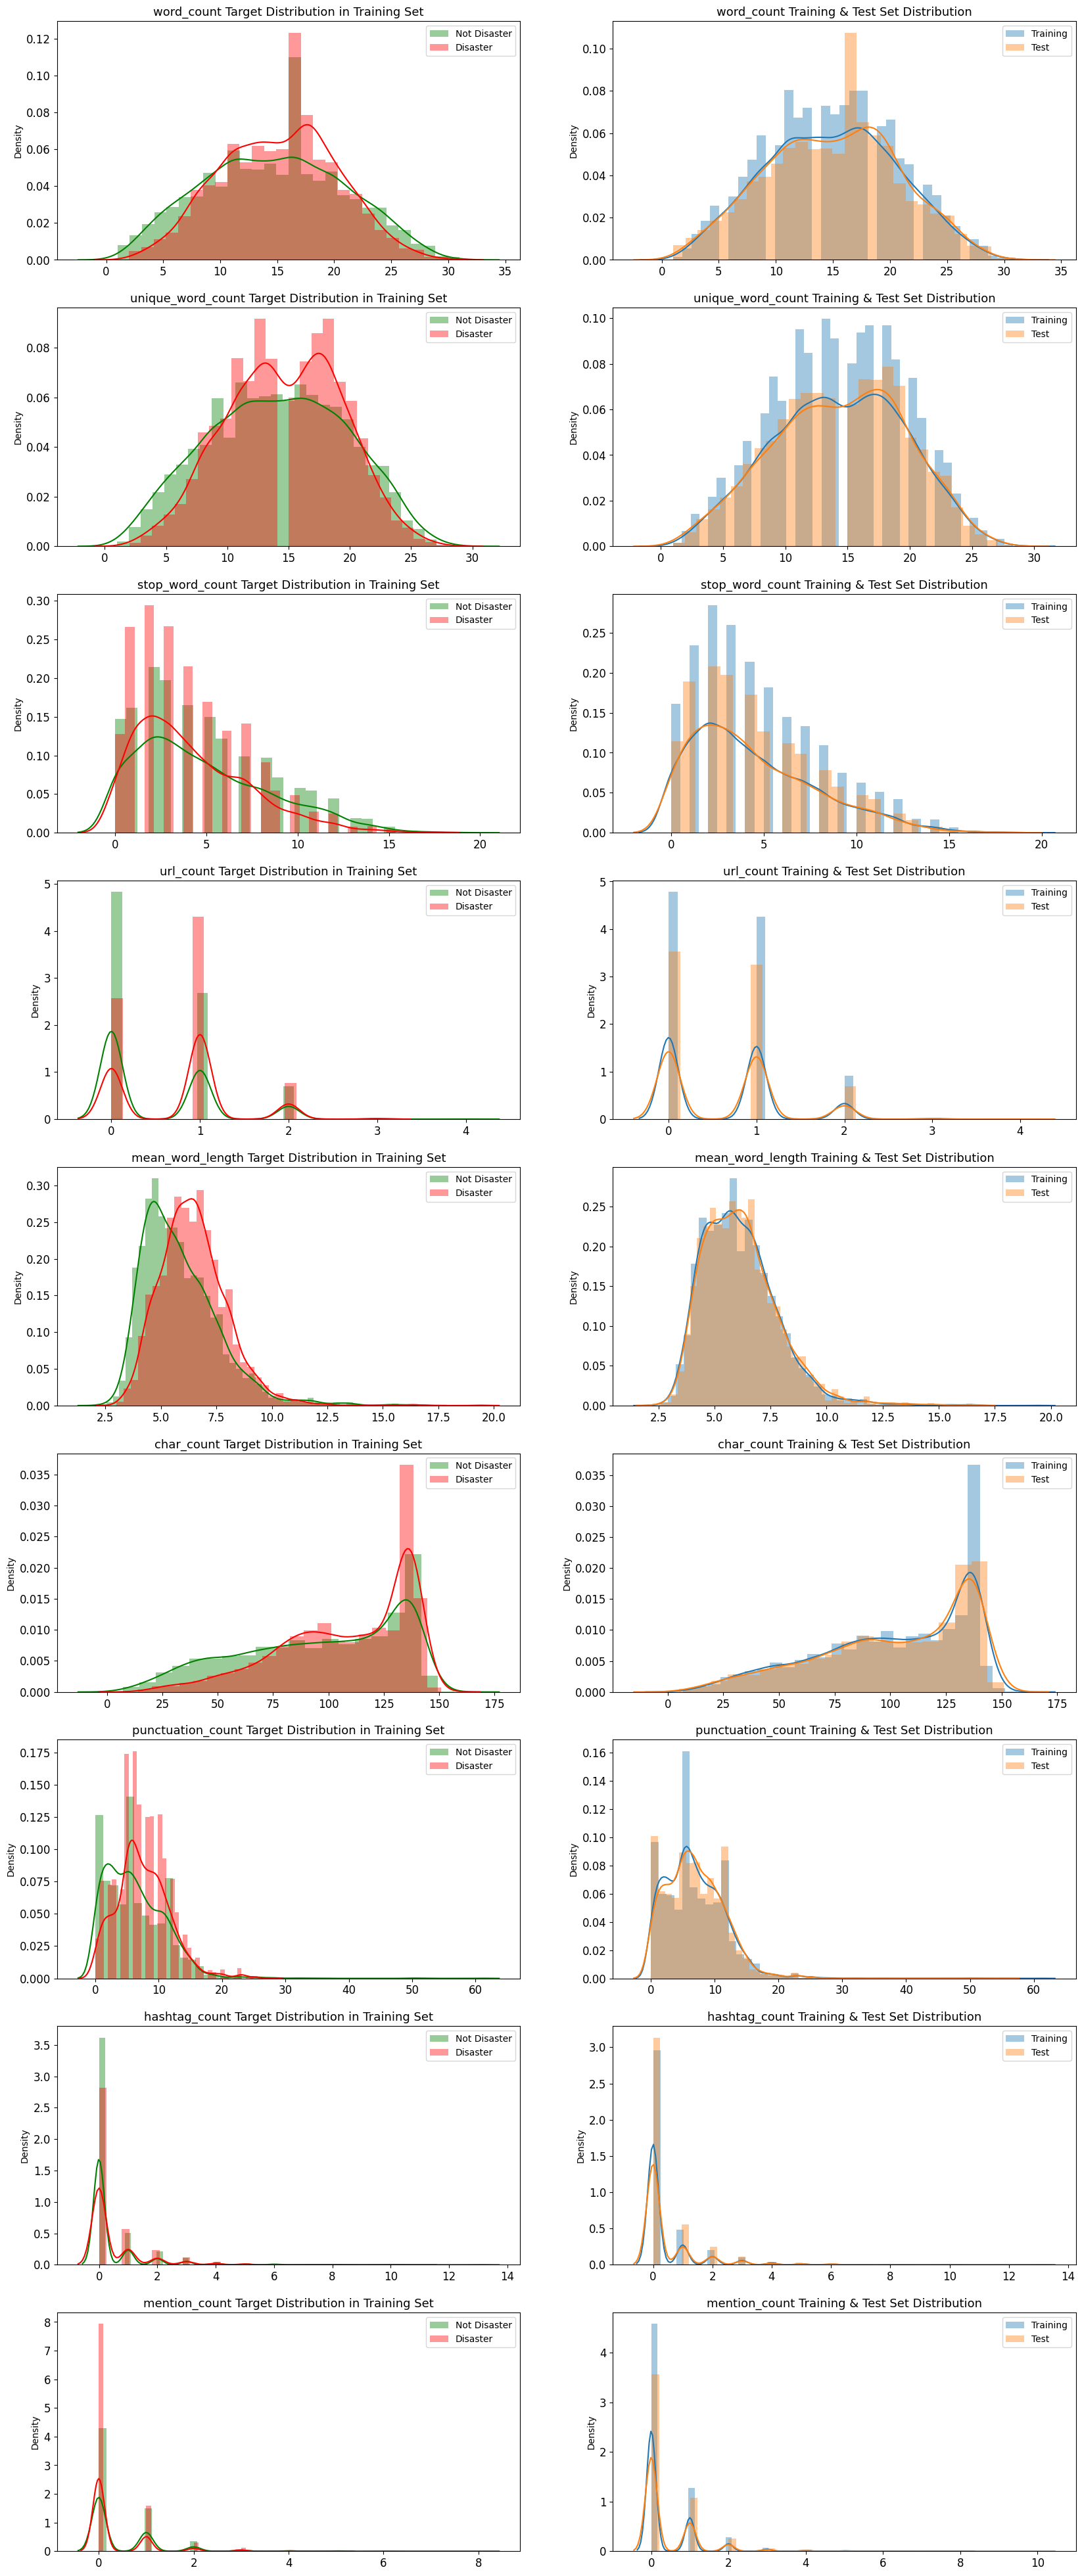

In [17]:
#Распределение метафункций в обучающем и тестовом наборах

METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']
DISASTER_TWEETS = df_train['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(df_train.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(df_train.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

    sns.distplot(df_train[feature], label='Training', ax=axes[i][1])
    sns.distplot(df_test[feature], label='Test', ax=axes[i][1])

    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()

    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

Все мета-функции имеют очень схожее распределение в обучающем и тестовом наборах.

In [18]:
df_train['text'].values[5]

'#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires'

In [19]:
#Удалим все нерелевантные символы

import re

def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "", regex=True)
    df[text_field] = df[text_field].str.replace(r"http", "", regex=True)
    df[text_field] = df[text_field].str.replace(r"@\S+", "", regex=True)
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ", regex=True)
    df[text_field] = df[text_field].str.replace(r"#", "", regex=True)
    df[text_field] = df[text_field].str.replace(r"@", "at", regex=True)
    df[text_field] = df[text_field].str.replace(r"%20", "at", regex=True)
    df[text_field] = df[text_field].str.lower()
    return df

df_train = standardize_text(df_train, "text")

df_train.to_csv("clean_train.csv")
df_train.head(5)

text  target  word_count  \
0  our deeds are the reason of this  earthquake m...       1          13   
1             forest fire near la ronge sask  canada       1           7   
2  all residents asked to 'shelter in place' are ...       1          22   
3  13,000 people receive  wildfires evacuation or...       1           8   
4  just got sent this photo from ruby  alaska as ...       1          16   

   unique_word_count  stop_word_count  url_count  mean_word_length  \
0                 13                6          0          4.384615   
1                  7                0          0          4.571429   
2                 20               11          0          5.090909   
3                  8                1          0          7.125000   
4                 15                7          0          4.500000   

   char_count  punctuation_count  hashtag_count  mention_count  
0          69                  1              1              0  
1          38                  1              0              0  
2         133                  3              0              0  
3          65                  2              1              0  
4          88                  2              2              0

In [20]:
df_train['text'].values[5]

' rockyfire update    california hwy  20 closed in both directions due to lake county fire    cafire  wildfires'

In [21]:
#Лемматизация

from string import punctuation
from pymystem3 import Mystem

mystem = Mystem()

def lemmatize_and_filter(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in stop_words and not token.isnumeric() \
              and token != " " \
              and token.strip() not in punctuation]

    text = " ".join(tokens)

    return text

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [22]:
lemmatize_and_filter(train['text'].values[5])

'rockyfire update california hwy closed directions due lake county fire cafire wildfires'

In [23]:
#from nltk.stem.snowball import SnowballStemmer

# инициализируем стеммер
#stemmer = SnowballStemmer("english")
#def stemmed(text):
    #text = " ".join([stemmer.stem(token) for token in text.split(' ')])

    #return text

In [24]:
#Сделаем теперь предобработку.
#data_preprocessed['text'] = df_train['text'].apply(lambda text: stemmed(lemmatize_and_filter(text)))
df_train['text_cleaned'] = df_train['text'].apply(lambda text: lemmatize_and_filter(text))
df_train['text_cleaned'].values[5]

'rockyfire update california hwy closed directions due lake county fire cafire wildfires'

In [25]:
#df_mislabeled = df_train.groupby(['text_cleaned']).nunique().sort_values(by='target', ascending=False)
#df_mislabeled = df_mislabeled[df_mislabeled['target'] > 1]['target']
#df_mislabeled.index.tolist()

In [26]:
#df_train['target_relabeled'] = df_train['target'].copy()
#df_train.loc[df_train['text_cleaned'] == 'foodscare offers2go nestleindia slips loss magginoodle ban unsafe hazardous humanconsumption', 'target_relabeled'] = 0

In [27]:
#Токенизация
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

df_train["tokens"] = df_train["text_cleaned"].apply(tokenizer.tokenize)
df_train.head()

text  target  word_count  \
0  our deeds are the reason of this  earthquake m...       1          13   
1             forest fire near la ronge sask  canada       1           7   
2  all residents asked to 'shelter in place' are ...       1          22   
3  13,000 people receive  wildfires evacuation or...       1           8   
4  just got sent this photo from ruby  alaska as ...       1          16   

   unique_word_count  stop_word_count  url_count  mean_word_length  \
0                 13                6          0          4.384615   
1                  7                0          0          4.571429   
2                 20               11          0          5.090909   
3                  8                1          0          7.125000   
4                 15                7          0          4.500000   

   char_count  punctuation_count  hashtag_count  mention_count  \
0          69                  1              1              0   
1          38                  1              0              0   
2         133                  3              0              0   
3          65                  2              1              0   
4          88                  2              2              0   

                                        text_cleaned  \
0       deeds reason earthquake may allah forgive us   
1              forest fire near la ronge sask canada   
2  residents asked shelter place notified officer...   
3  people receive wildfires evacuation orders cal...   
4  got sent photo ruby alaska smoke wildfires pou...   

                                              tokens  
0  [deeds, reason, earthquake, may, allah, forgiv...  
1      [forest, fire, near, la, ronge, sask, canada]  
2  [residents, asked, shelter, place, notified, o...  
3  [people, receive, wildfires, evacuation, order...  
4  [got, sent, photo, ruby, alaska, smoke, wildfi...

In [28]:
df_train['tokens'].values[5]

['rockyfire',
 'update',
 'california',
 'hwy',
 'closed',
 'directions',
 'due',
 'lake',
 'county',
 'fire',
 'cafire',
 'wildfires']

In [29]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

all_words = [word for tokens in df_train["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in df_train["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s всего слов, при объеме словарного запаса  %s" % (len(all_words), len(VOCAB)))
print("Max длина предложения %s" % max(sentence_lengths))

66587 всего слов, при объеме словарного запаса  14236
Max длина предложения 23


In [30]:
print(all_words)
print(VOCAB)

['deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'us', 'forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada', 'residents', 'asked', 'shelter', 'place', 'notified', 'officers', 'evacuation', 'shelter', 'place', 'orders', 'expected', 'people', 'receive', 'wildfires', 'evacuation', 'orders', 'california', 'got', 'sent', 'photo', 'ruby', 'alaska', 'smoke', 'wildfires', 'pours', 'school', 'rockyfire', 'update', 'california', 'hwy', 'closed', 'directions', 'due', 'lake', 'county', 'fire', 'cafire', 'wildfires', 'flood', 'disaster', 'heavy', 'rain', 'causes', 'flash', 'flooding', 'streets', 'manitou', 'colorado', 'springs', 'areas', 'top', 'hill', 'see', 'fire', 'woods', 'emergency', 'evacuation', 'happening', 'building', 'across', 'street', 'afraid', 'tornado', 'coming', 'area', 'three', 'people', 'died', 'heat', 'wave', 'far', 'haha', 'south', 'tampa', 'getting', 'flooded', 'hah', 'wait', 'second', 'live', 'south', 'tampa', 'gonna', 'gonna', 'fvck', 'flooding', 'raining', 'f

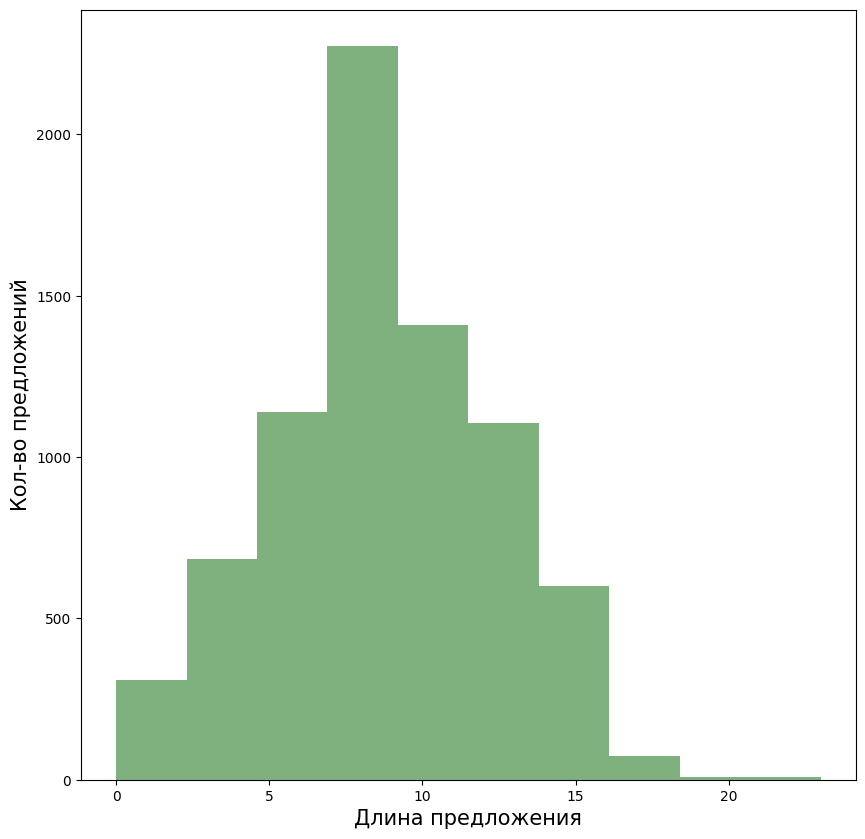

In [31]:
#Длина предложения и кол-во предложений
fig = plt.figure(figsize=(10, 10))
plt.xlabel('Длина предложения', fontsize=15)
plt.ylabel('Кол-во предложений', fontsize=15)
plt.hist(sentence_lengths, color = 'darkgreen',  alpha=0.5)
plt.show()


Естественным способом представления текста для компьютеров является кодирование каждого символа по отдельности, это кажется совершенно недостаточным для представления и понимания языка. Наша цель - сначала создать полезное вложение для каждого предложения (или твита) в нашем наборе данных, а затем использовать эти вложения для точного прогнозирования соответствующей категории.

Самый простой подход, с которого мы можем начать, - это использовать модель набора слов и применить сверху логистическую регрессию. Набор слов просто связывает индекс с каждым словом в нашем словаре и вставляет каждое предложение в виде списка из 0, с 1 в каждом индексе, соответствующем слову, присутствующему в предложении.

In [32]:
#Bag of Words

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = df_train["text_cleaned"].tolist()
list_labels = df_train["target"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2,
                                                                                random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

Попробуем визуализировать, насколько хорошо разделены твиты и имеют отношение к катастрофам или нет (класс `Катастрофа` - target=1 и класс `Не катастрофа` -target=0). Используем метод главных компонент (PCA) и спроецируем данные на два измерения.

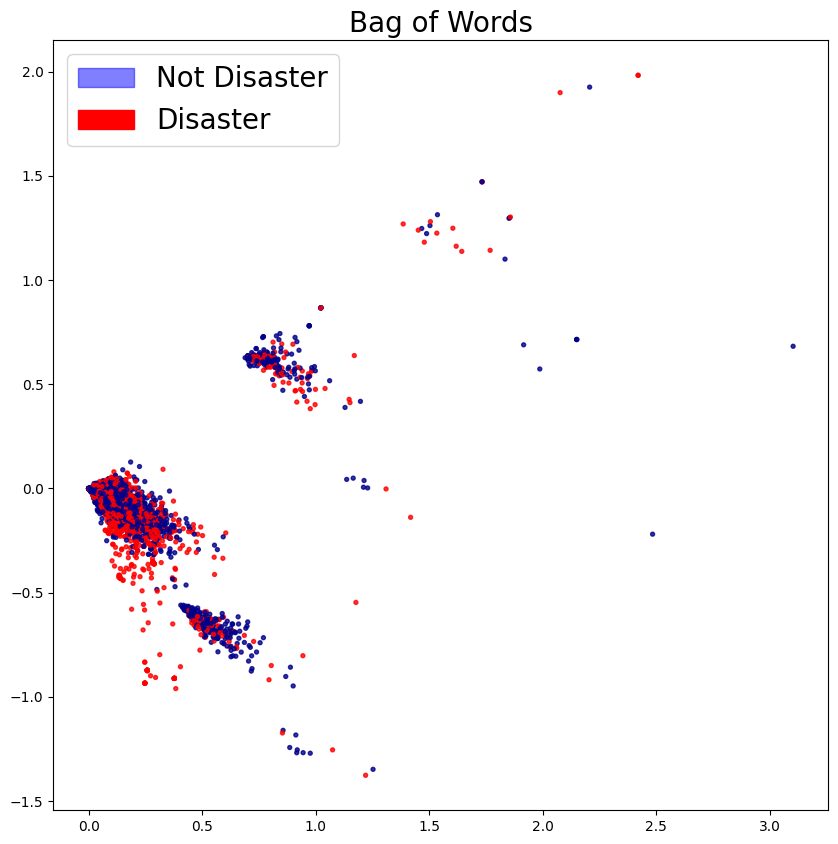

In [33]:
#PCA

from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['darkblue','red']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='blue', label='Not Disaster', alpha=0.5)
            blue_patch = mpatches.Patch(color='red', label='Disaster')
            plt.legend(handles=[red_patch, blue_patch], prop={'size': 20})


fig = plt.figure(figsize=(10, 10))
plot_LSA(X_train_counts, y_train)
plt.title('Bag of Words', fontsize=20)
plt.show()



По графику видно, что два класса не разделены как следует, возможно это просто эффект сокращения размерности.
Посмотрим какие результаты будут после обучения.

### LogisticRegression & CatBoostClassifier

In [34]:
# LogisticRegression + Bag of Words
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

In [35]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')

    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')

    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.807, precision = 0.809, recall = 0.807, f1 = 0.805


In [36]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 9.6 MB/s eta 0:00:00


In [37]:
#CatBoostClassifier + Bag of Words
from catboost import CatBoostClassifier

cat_clf = CatBoostClassifier(iterations=300, logging_level='Silent')
cat_clf.fit(X_train_counts, y_train)

y_predicted_cat = cat_clf.predict(X_test_counts)

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_cat)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.791, precision = 0.803, recall = 0.791, f1 = 0.785


Ожидала, что `CatBoost` даст показатель f1 выше, однако у `LogisticRegression` f1 = 0.805 - не плохой показатель, попробуем найти, какие ошибки допускает наш классификатор. Давайте начнем с рассмотрения `Confusion Matrix`.

In [84]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          display_labels=["Not Disaster","Disaster"],
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.rcParams.update({'font.size': 20})

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="black" if cm[i, j] < thresh else "white", fontsize=20)


    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

    return plt

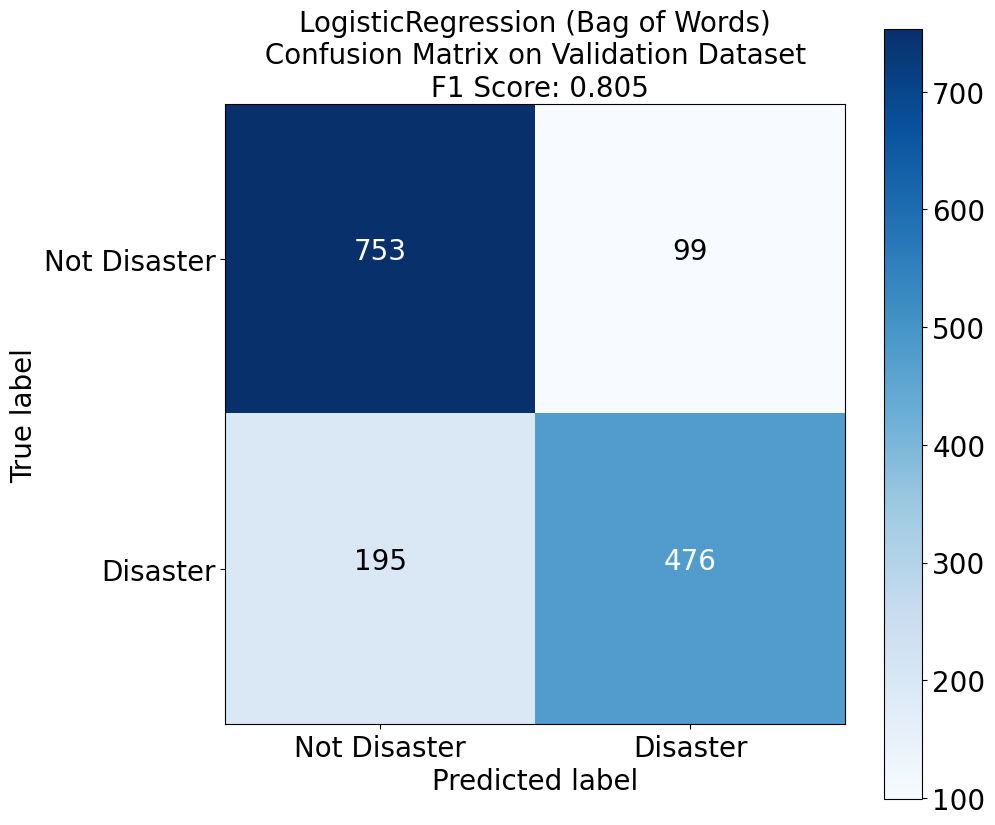

In [86]:
#LogisticRegression (Bag of Words) - Confusion_matrix

cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Not Disaster','Disaster'], normalize=False, title='Confusion matrix')
f1_lr_bow = f1_score(y_test, y_predicted_counts, pos_label=None, average='weighted')

plt.title("LogisticRegression (Bag of Words)\n Confusion Matrix on Validation" + " Dataset \n F1 Score: " + str(f1_lr_bow.round(3)),fontsize=20)

plt.show()

Классификатор создает больше ложноотрицательных (TN), чем ложноположительных (FN) срабатываний. В зависимости от варианта использования это кажется желательным (например, ложноположительный результат - довольно высокая стоимость для правоохранительных органов).

Посмотрим на топ-10 слов, с помощью которых построен `Confusion Matrix`

In [40]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}

    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

In [41]:
print(importance[0],'tops')

{'tops': [(1.6133802401133288, 'japan'), (1.7180091378394768, 'floods'), (1.7423087063054252, 'massacre'), (1.7457084017392155, 'bombing'), (1.8188744849627525, 'derailment'), (1.9802391449625099, 'typhoon'), (2.0694659740230334, 'earthquake'), (2.1461652064494774, 'wildfire'), (2.2872674283808485, 'fires'), (2.507388337593678, 'hiroshima')], 'bottom': [(-1.078967956145386, 'poll'), (-1.079942965107176, 'full'), (-1.0843169781026218, 'harm'), (-1.1020866667353533, 'jobs'), (-1.1142089082135496, 'better'), (-1.177318772832285, 'nowplaying'), (-1.2005635833568018, 'eyes'), (-1.2596318471758632, 'bags'), (-1.3429588514463224, 'love'), (-1.4033461935058344, 'ruin')]} tops


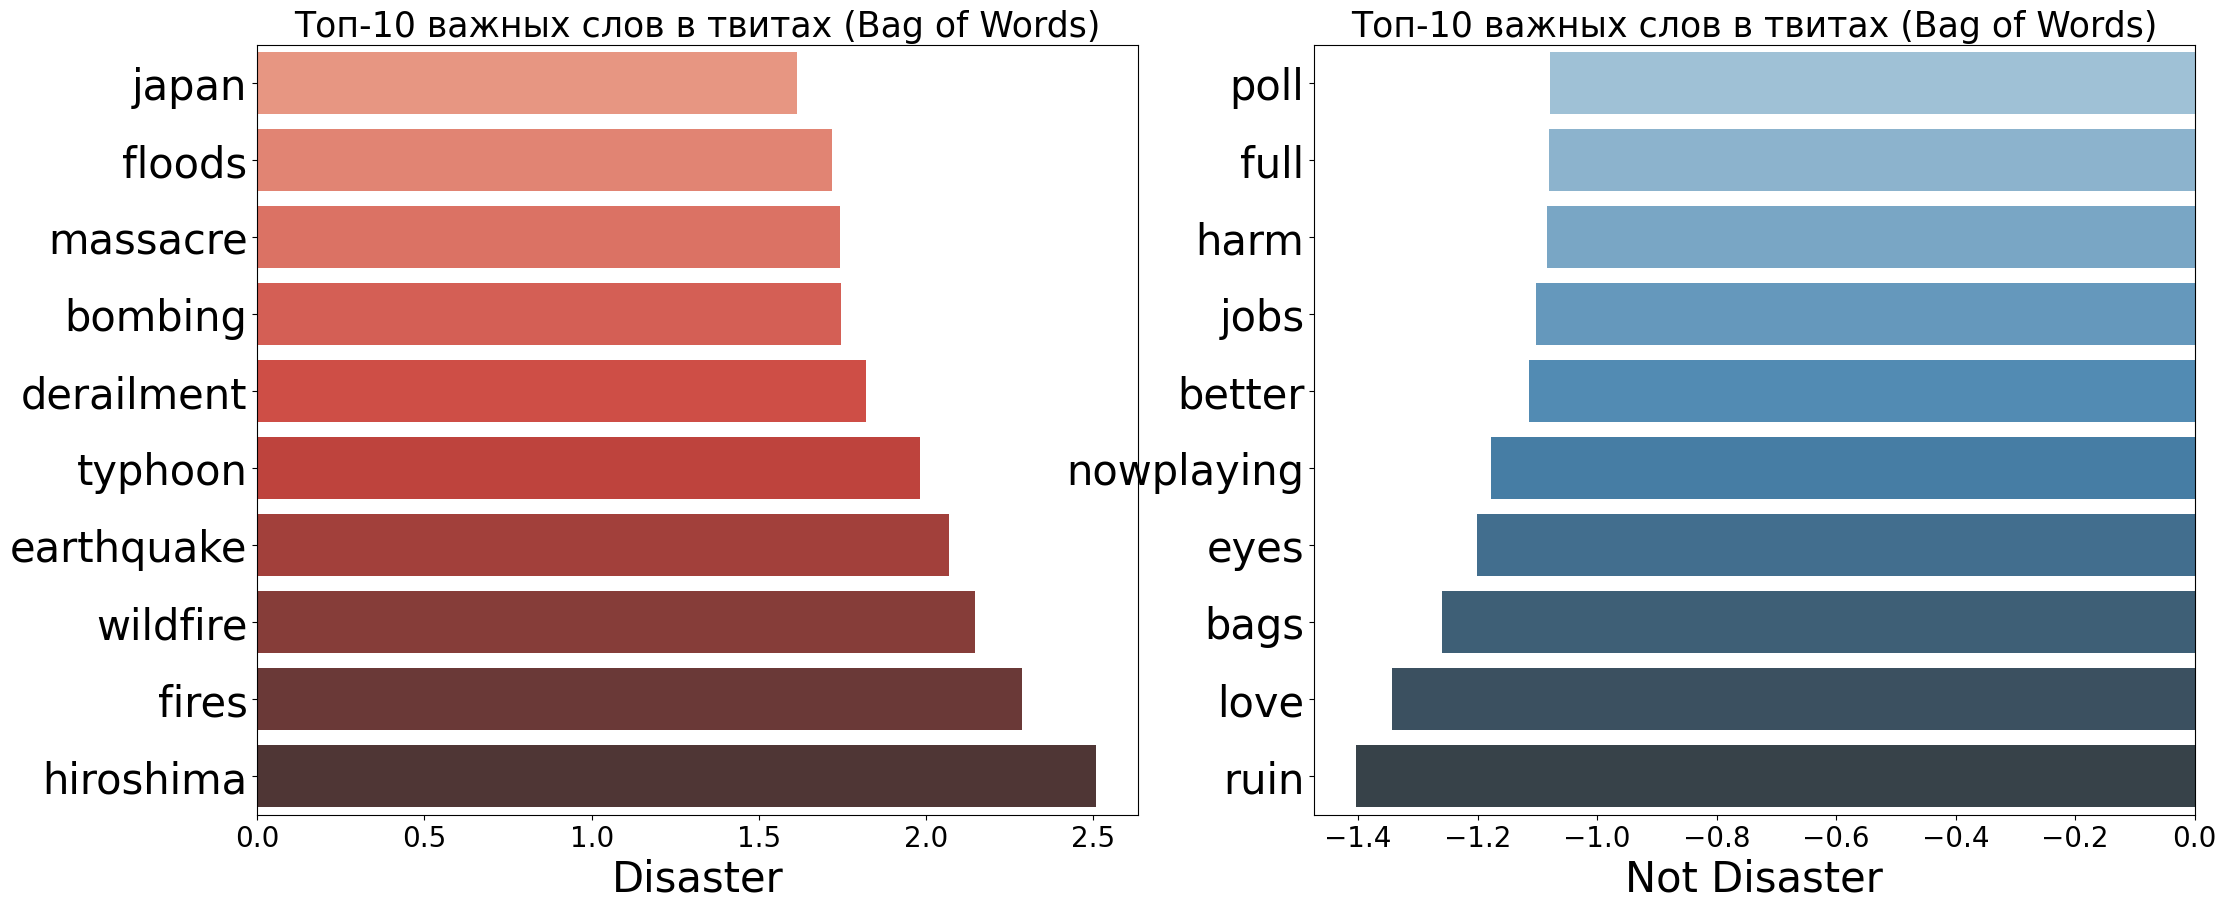

In [42]:
# Топ-10 слов для модели Bag of Words

def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])

    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)

    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]

    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]

    # left side, the plot for keywords in disastrous tweets
    fig, ax_ = plt.subplots(1, 2, figsize = (25,10))

    sns.barplot(x = top_scores, # count of each keyword
                y = top_words, # index of this df is our keywords
                ax = ax_[0],
                palette = 'Reds_d', label = 'dis').set_title(name, fontsize = 25)
    # right side, the plot for non_disastrous tweets
    sns.barplot(x = bottom_scores, y = bottom_words,
                ax = ax_[1], palette = 'Blues_d', label = 'non_dis').set_title(name, fontsize = 25)

    for ax in [ax_[0], ax_[1]]:
        ax.set_ylabel('')
        ax.set_xlabel('Disaster',fontsize = 30)
        ax.set_yticklabels(labels =ax.get_yticklabels() ,
                       fontsize = 30)

    for ax in [ax_[1]]:
        ax.set_ylabel('')
        ax.set_xlabel('Not Disaster',fontsize = 30 )
        ax.set_yticklabels(labels =ax.get_yticklabels('') ,
                       fontsize = 30)

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]
plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Топ-10 важных слов в твитах (Bag of Words)")

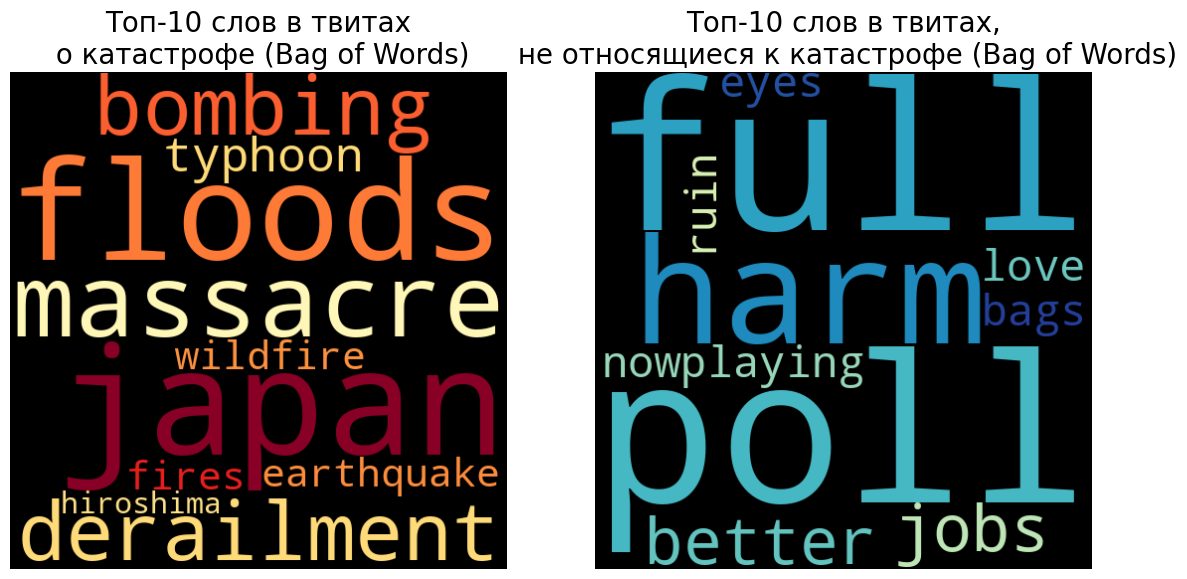

In [43]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud


#  1.  SUBPLOTS - Create the two word strings
#  Episode IV: A New Hope
wc_string_1 = ' '.join(top_words)

#  Episode V: The Empire Strikes Back
wc_string_2 = ' '.join(bottom_words)



#  2.  SUBPLOTS - Generate the two word clouds
wordcloud_1 = WordCloud(width = 500, height = 500,    # resolution
                  colormap = 'YlOrRd',                # font colors from palette
                  background_color ='black',          # background color
                  #stopwords = stopwords,              # remove common words
                  normalize_plurals = True,           # plurals to singular
                  repeat = False,                      # repeat words
                  min_font_size = 10).generate(wc_string_1)

wordcloud_2 = WordCloud(width = 500, height = 500,    # resolution
                  colormap = 'YlGnBu',                # font colors from palette
                  background_color ='black',          # background color
                  #stopwords = stopwords,              # remove common words
                  normalize_plurals = True,           # plurals to singular
                  repeat = False,                      # repeat words
                  min_font_size = 10).generate(wc_string_2)


#  3.  SUBPLOTS - Plot the two word clouds
fig = plt.figure(figsize=(12,6))

#  subplot #1
plt.subplot(121)
plt.title('Топ-10 слов в твитах\n о катастрофе (Bag of Words)',fontsize=20)
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis("off")

#  subplot #2
plt.subplot(122)
plt.title('Топ-10 слов в твитах,\n не относящиеся к катастрофе (Bag of Words)',fontsize=20)
plt.imshow(wordcloud_2, interpolation='bilinear')
plt.axis("off")

plt.tight_layout()
plt.show()

In [44]:
#TFIDF
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

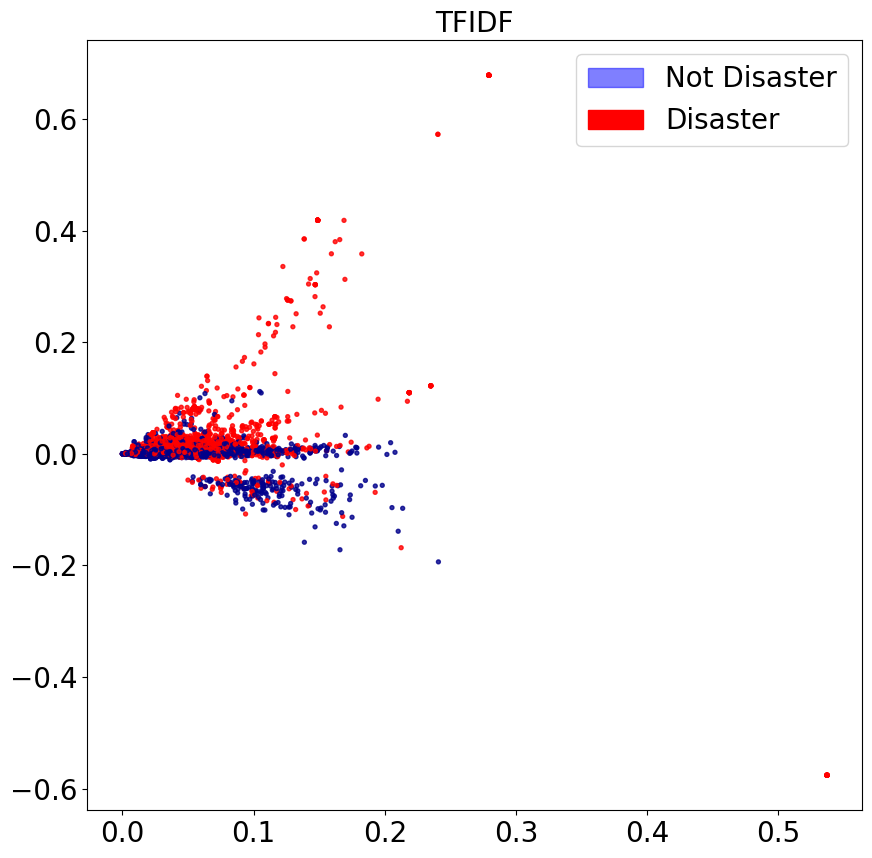

In [45]:
fig = plt.figure(figsize=(10, 10))
plot_LSA(X_train_tfidf, y_train)
plt.title('TFIDF',fontsize=20)
plt.show()

In [46]:
#LogisticRegression + TFIDF
clf_tfidf = LogisticRegression()
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf,
                                                                       recall_tfidf, f1_tfidf))

accuracy = 0.815, precision = 0.821, recall = 0.815, f1 = 0.812


In [47]:
#CatBoostClassifier + TFIDF
cat_clf = CatBoostClassifier(iterations=300, logging_level='Silent')
cat_clf.fit(X_train_tfidf, y_train)

y_predicted_cat_tfidf = cat_clf.predict(X_test_tfidf)

accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_cat_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf,
                                                                       recall_tfidf, f1_tfidf))

accuracy = 0.795, precision = 0.807, recall = 0.795, f1 = 0.789


`LogisticRegression` f1=0,812 показатель чуть лучше с `TFIDF`, построем `Confusion_matrix`

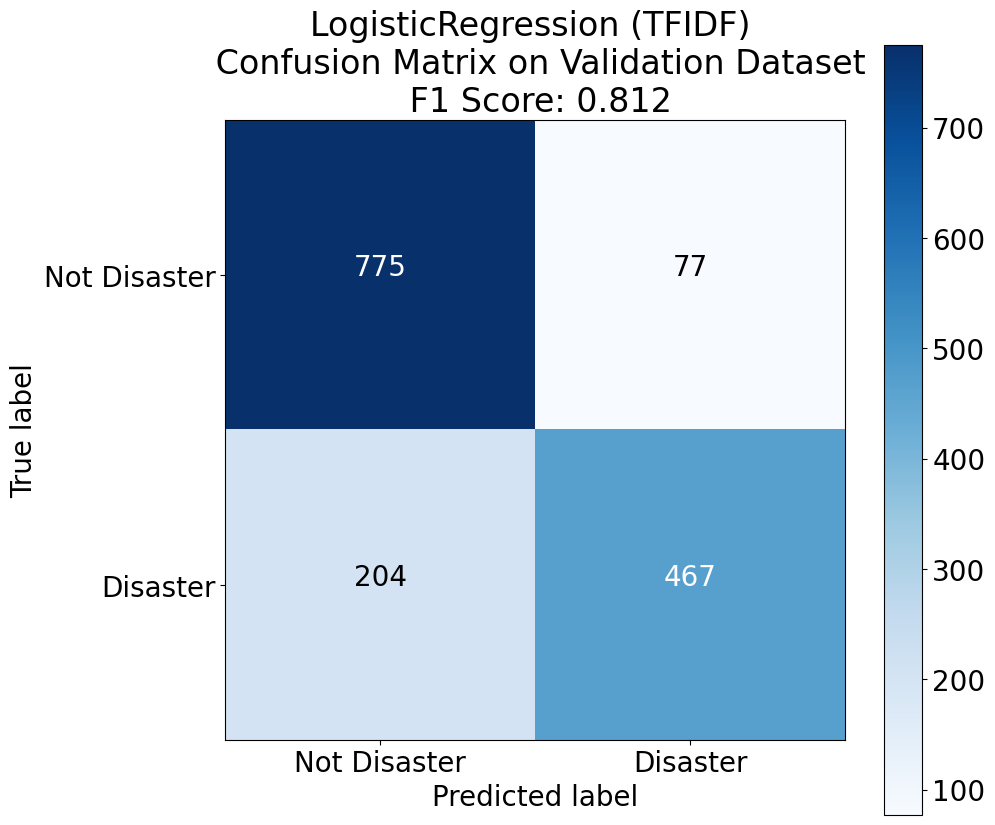

In [87]:
#LogisticRegression (TFIDF) - Confusion_matrix
cm2 = confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['Not Disaster','Disaster'], normalize=False, title='Confusion matrix')
f1_lr_tfidf = f1_score(y_test, y_predicted_tfidf, pos_label=None, average='weighted')
plt.title("LogisticRegression (TFIDF) \n Confusion Matrix on Validation" + " Dataset\n F1 Score: " + str(f1_lr_tfidf.round(3)))
plt.show()

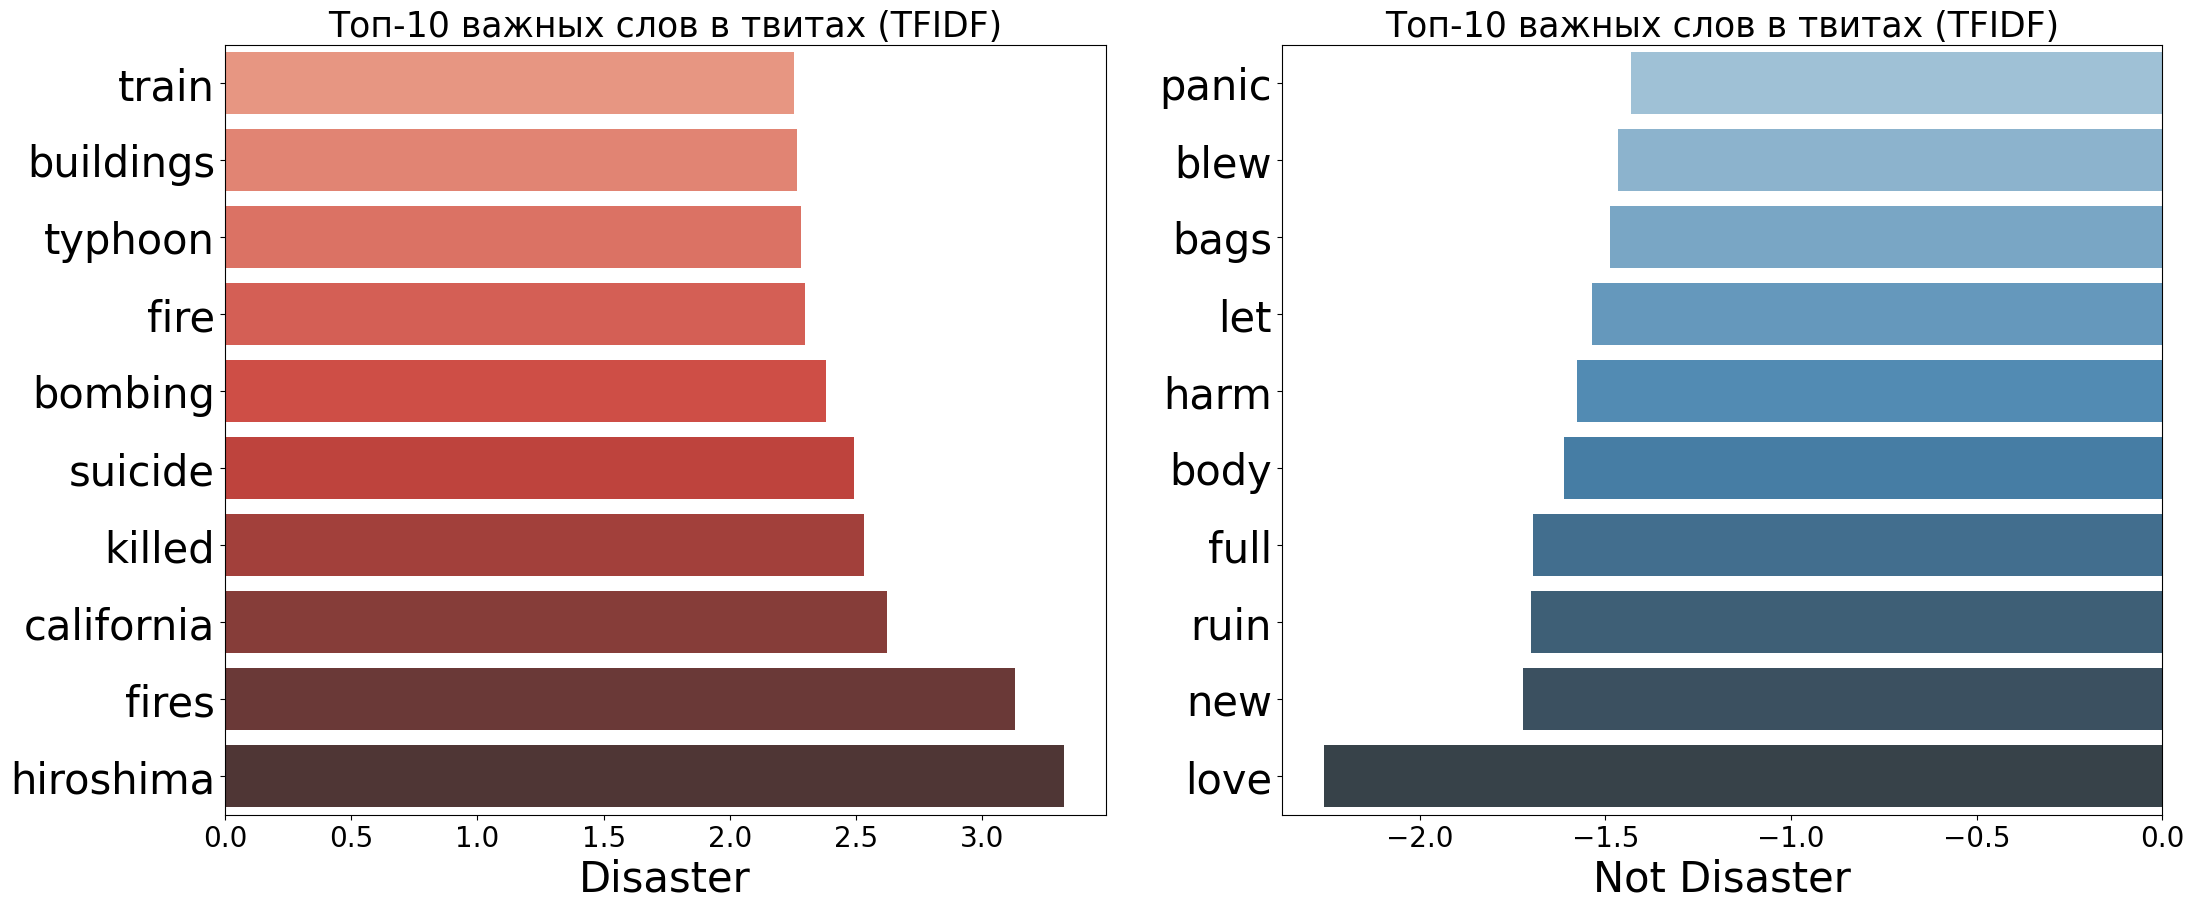

In [49]:
# Топ-10 слов для модели TFIDF
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

top_scores = [a[0] for a in importance_tfidf[0]['tops']]
top_words = [a[1] for a in importance_tfidf[0]['tops']]
bottom_scores = [a[0] for a in importance_tfidf[0]['bottom']]
bottom_words = [a[1] for a in importance_tfidf[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Топ-10 важных слов в твитах (TFIDF)")

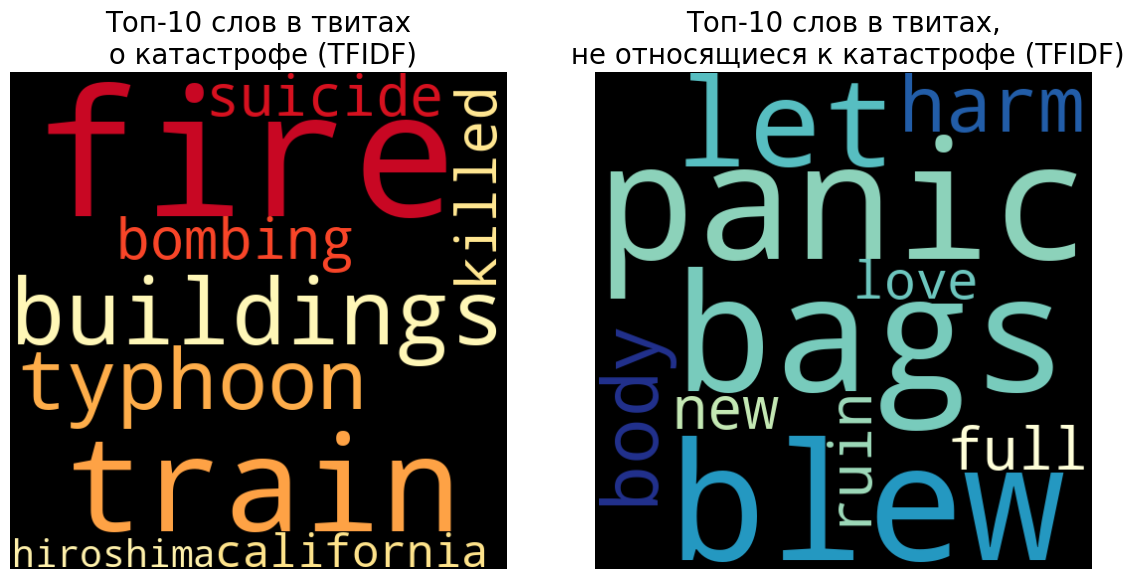

In [50]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud


#  1.  SUBPLOTS - Create the two word strings
#  Episode IV: A New Hope
wc_string_1 = ' '.join(top_words)

#  Episode V: The Empire Strikes Back
wc_string_2 = ' '.join(bottom_words)



#  2.  SUBPLOTS - Generate the two word clouds
wordcloud_1 = WordCloud(width = 500, height = 500,    # resolution
                  colormap = 'YlOrRd',                # font colors from palette
                  background_color ='black',          # background color
                  #stopwords = stopwords,              # remove common words
                  normalize_plurals = True,           # plurals to singular
                  repeat = False,                      # repeat words
                  min_font_size = 10).generate(wc_string_1)

wordcloud_2 = WordCloud(width = 500, height = 500,    # resolution
                  colormap = 'YlGnBu',                # font colors from palette
                  background_color ='black',          # background color
                  #stopwords = stopwords,              # remove common words
                  normalize_plurals = True,           # plurals to singular
                  repeat = False,                      # repeat words
                  min_font_size = 10).generate(wc_string_2)


#  3.  SUBPLOTS - Plot the two word clouds
fig = plt.figure(figsize=(12,6))

#  subplot #1
plt.subplot(121)
plt.title('Топ-10 слов в твитах\n о катастрофе (TFIDF)', fontsize=20)
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis("off")

#  subplot #2
plt.subplot(122)
plt.title('Топ-10 слов в твитах,\n не относящиеся к катастрофе (TFIDF)', fontsize=20)
plt.imshow(wordcloud_2, interpolation='bilinear')
plt.axis("off")

plt.tight_layout()
plt.show()

Построим получится ли уличшить результаты с алгоримом Word2Vec

In [51]:
import gensim.downloader as api

word2vec = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [52]:
#Word2Vec

def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, df_train, generate_missing=False):
    embeddings = df_train['tokens'].apply(lambda x: get_average_word2vec(x, vectors,
                                                                                generate_missing=generate_missing))
    return list(embeddings)



In [53]:
embeddings = get_word2vec_embeddings(word2vec, df_train)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels,
                                                                                        test_size=0.2, random_state=40)

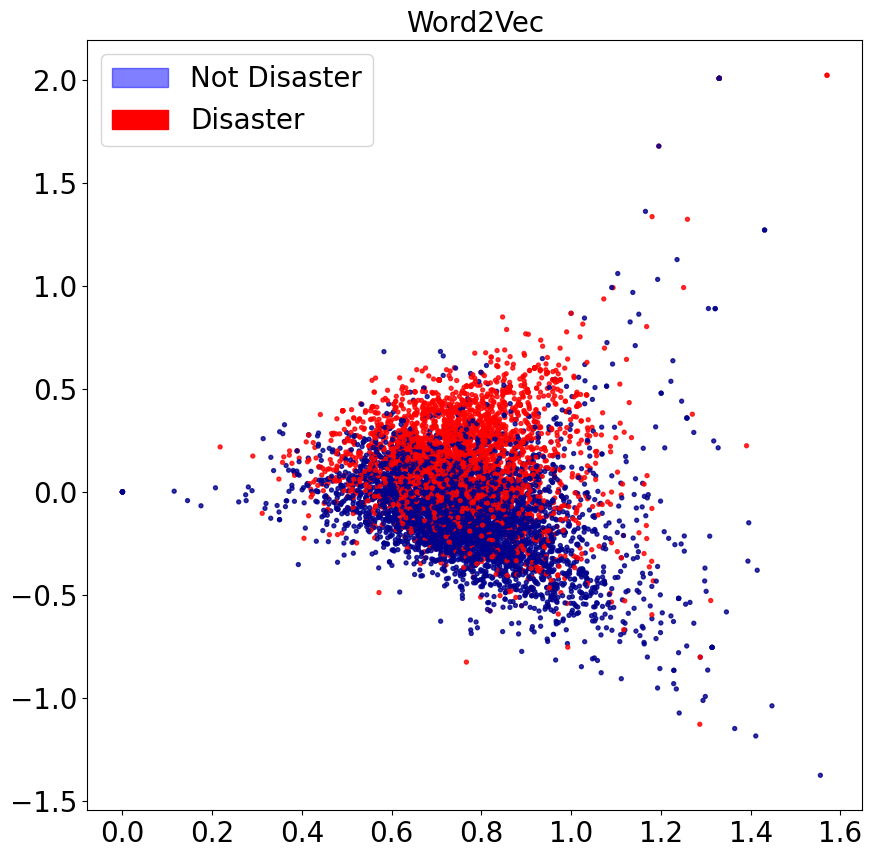

In [54]:
fig = plt.figure(figsize=(10, 10))
plot_LSA(embeddings, list_labels)
plt.title('Word2Vec', fontsize=20)
plt.show()

In [55]:
#LogisticRegression + Word2Vec
clf_w2v = LogisticRegression()
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec,
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.798, precision = 0.799, recall = 0.798, f1 = 0.796


In [56]:
#CatBoostClassifier + Word2Vec
cat_clf = CatBoostClassifier(iterations=300, logging_level='Silent')
cat_clf.fit(X_train_word2vec, y_train_word2vec)

y_predicted_cat_word2vec= cat_clf.predict(X_test_word2vec)

accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_cat_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec,
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.815, precision = 0.817, recall = 0.815, f1 = 0.813


`CatBoostClassifier` с `Word2Vec` показал довольно не плохой результат f=0.813, почти аналогичный результату `LogisticRegression` с `TFIDF` (f=0.812).

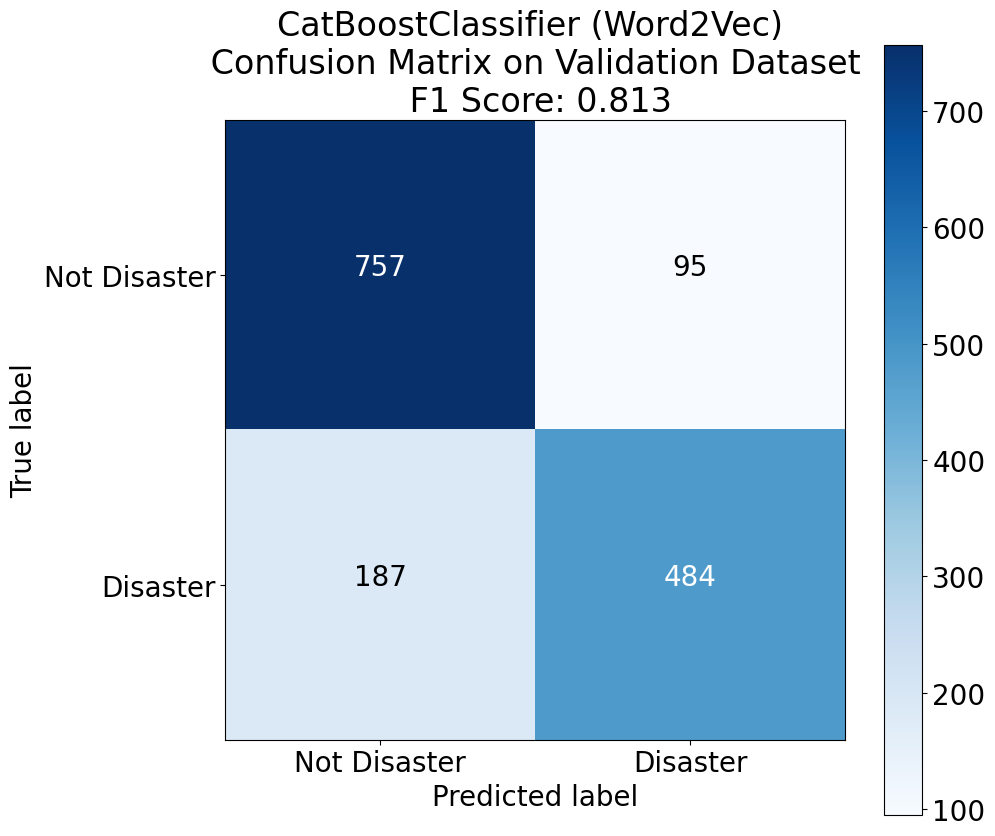

In [88]:
cm_w2v = confusion_matrix(y_test_word2vec, y_predicted_cat_word2vec)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm_w2v, classes=['Not Disaster','Disaster'], normalize=False, title='Confusion matrix')
f1_cat = f1_score(y_test_word2vec, y_predicted_cat_word2vec, pos_label=None, average='weighted')
plt.title("CatBoostClassifier (Word2Vec) \n Confusion Matrix on Validation" + " Dataset \n F1 Score: " + str(f1_cat.round(3)))
plt.show()

In [58]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=7881e79fab0e607d7f8223036e7558c169595a52174d8f3e4bda91e1d045ba6c
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [59]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(list_corpus, list_labels, test_size=0.2,
                                                                                random_state=40)
vector_store = word2vec
def word2vec_pipeline(examples):
    global vector_store
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized_list = []
    for example in examples:
        example_tokens = tokenizer.tokenize(example)
        vectorized_example = get_average_word2vec(example_tokens, vector_store, generate_missing=False, k=300)
        tokenized_list.append(vectorized_example)
    return clf_w2v.predict_proba(tokenized_list)

c = make_pipeline(count_vectorizer, clf)

In [60]:
def explain_one_instance(instance, class_names):
    explainer = LimeTextExplainer(class_names=class_names)
    exp = explainer.explain_instance(instance, word2vec_pipeline, num_features=6)
    return exp

def visualize_one_exp(features, labels, index, class_names = ["Not Disaster","Disaster"]):
    exp = explain_one_instance(features[index], class_names = class_names)
    print('Index: %d' % index)
    print('True class: %s' % class_names[labels[index]])
    exp.show_in_notebook(text=True)

In [61]:
import random
from collections import defaultdict

random.seed(40)

def get_statistical_explanation(test_set, sample_size, word2vec_pipeline, label_dict):
    sample_sentences = random.sample(test_set, sample_size)
    explainer = LimeTextExplainer()

    labels_to_sentences = defaultdict(list)
    contributors = defaultdict(dict)

    # First, find contributing words to each class
    for sentence in sample_sentences:
        probabilities = word2vec_pipeline([sentence])
        curr_label = probabilities[0].argmax()
        labels_to_sentences[curr_label].append(sentence)
        exp = explainer.explain_instance(sentence, word2vec_pipeline, num_features=6, labels=[curr_label])
        listed_explanation = exp.as_list(label=curr_label)

        for word,contributing_weight in listed_explanation:
            if word in contributors[curr_label]:
                contributors[curr_label][word].append(contributing_weight)
            else:
                contributors[curr_label][word] = [contributing_weight]

    # average each word's contribution to a class, and sort them by impact
    average_contributions = {}
    sorted_contributions = {}
    for label,lexica in contributors.items():
        curr_label = label
        curr_lexica = lexica
        average_contributions[curr_label] = pd.Series(index=curr_lexica.keys())
        for word,scores in curr_lexica.items():
            average_contributions[curr_label].loc[word] = np.sum(np.array(scores))/sample_size
        detractors = average_contributions[curr_label].sort_values()
        supporters = average_contributions[curr_label].sort_values(ascending=False)
        sorted_contributions[label_dict[curr_label]] = {
            'detractors':detractors,
             'supporters': supporters
        }
    return sorted_contributions

label_to_text = {
    0: 'Not Disaster',
    1: 'Disaster'
}
sorted_contributions = get_statistical_explanation(X_test_data, 100, word2vec_pipeline, label_to_text)

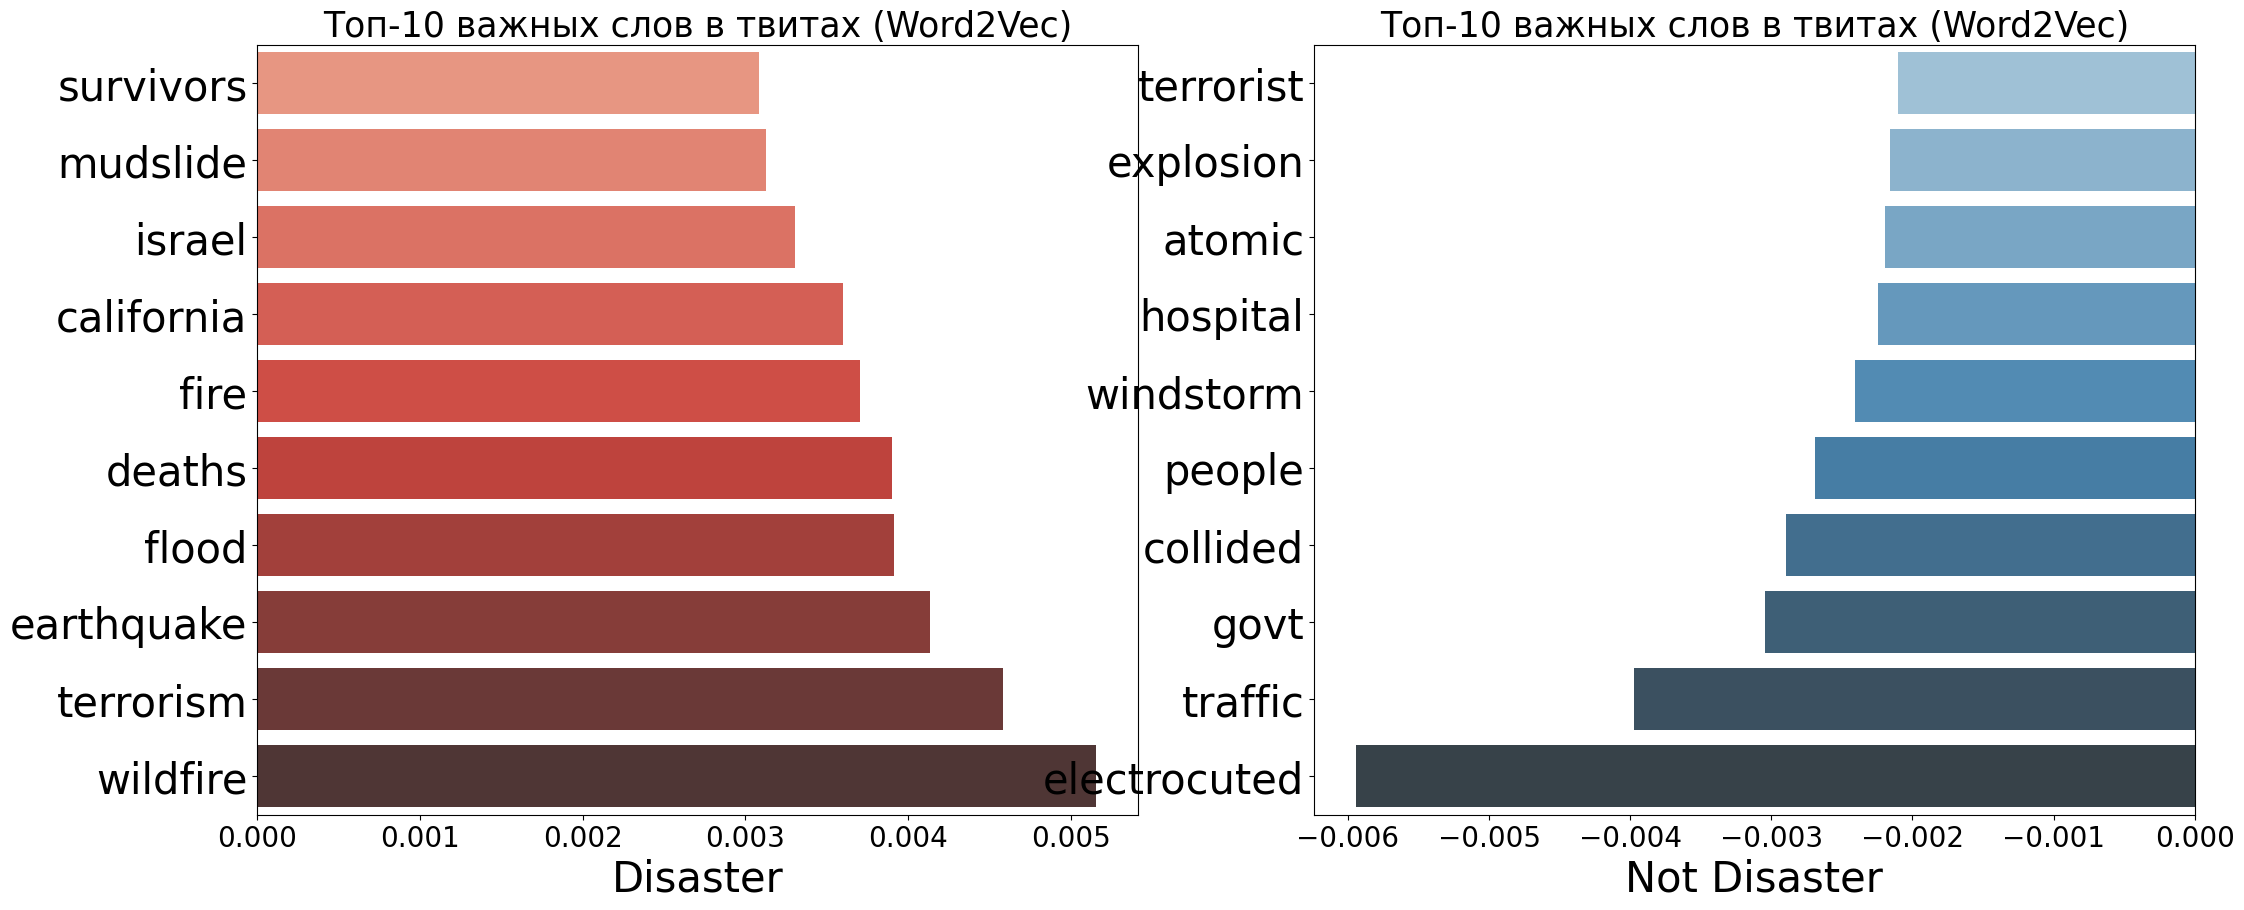

In [62]:
top_words = sorted_contributions['Disaster']['supporters'][:10].index.tolist()
top_scores = sorted_contributions['Disaster']['supporters'][:10].tolist()
bottom_words = sorted_contributions['Not Disaster']['detractors'][:10].index.tolist()
bottom_scores = sorted_contributions['Not Disaster']['detractors'][:10].tolist()

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Топ-10 важных слов в твитах (Word2Vec)")

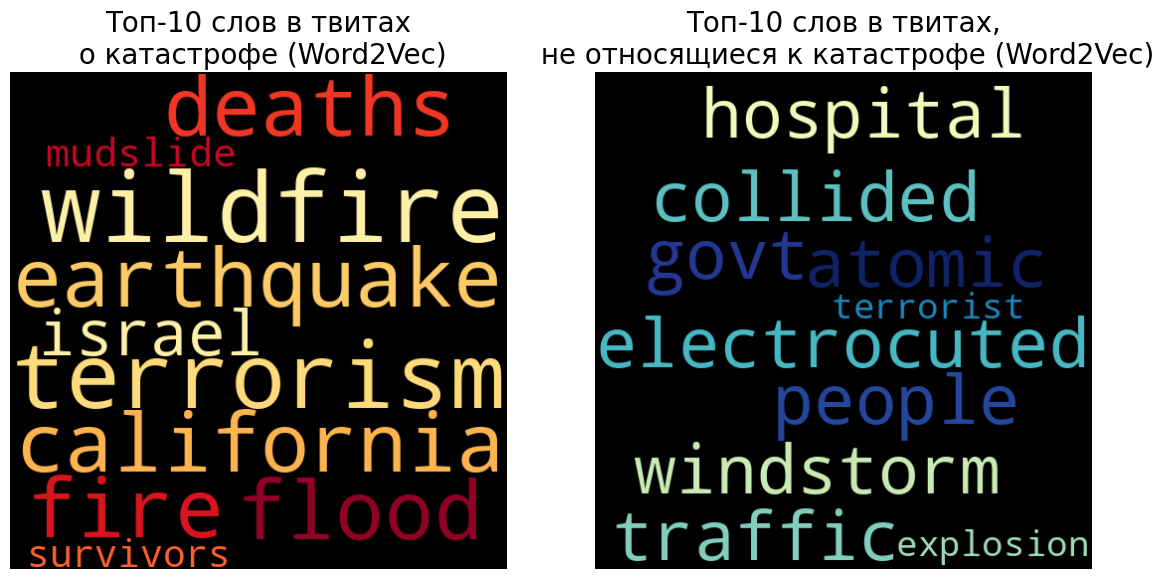

In [63]:
# Топ-10 слов для модели Word2Vec

#  1.  SUBPLOTS - Create the two word strings
#  Episode IV: A New Hope
wc_string_1 = ' '.join(top_words)

#  Episode V: The Empire Strikes Back
wc_string_2 = ' '.join(bottom_words)



#  2.  SUBPLOTS - Generate the two word clouds
wordcloud_1 = WordCloud(width = 500, height = 500,    # resolution
                  colormap = 'YlOrRd',                # font colors from palette
                  background_color ='black',          # background color
                  #stopwords = stopwords,              # remove common words
                  normalize_plurals = True,           # plurals to singular
                  repeat = False,                      # repeat words
                  min_font_size = 10).generate(wc_string_1)

wordcloud_2 = WordCloud(width = 500, height = 500,    # resolution
                  colormap = 'YlGnBu',                # font colors from palette
                  background_color ='black',          # background color
                  #stopwords = stopwords,              # remove common words
                  normalize_plurals = True,           # plurals to singular
                  repeat = False,                      # repeat words
                  min_font_size = 10).generate(wc_string_2)


#  3.  SUBPLOTS - Plot the two word clouds
fig = plt.figure(figsize=(12,6))

#  subplot #1
plt.subplot(121)
plt.title('Топ-10 слов в твитах\n о катастрофе (Word2Vec)',fontsize=20)
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis("off")

#  subplot #2
plt.subplot(122)
plt.title('Топ-10 слов в твитах,\n не относящиеся к катастрофе (Word2Vec)',fontsize=20)
plt.imshow(wordcloud_2, interpolation='bilinear')
plt.axis("off")

plt.tight_layout()
plt.show()

### DistilBERT
Текстовые входные данные должны быть преобразованы в числовые идентификаторы токенов и упорядочены в нескольких тензорах перед вводом в BERT.

Модель BertClassifier может быть сконфигурирована на уровне препроцессора, и в этом случае она автоматически применяет предварительную обработку к необработанным входным данным во время fit(), predict() и evaluate(). Это делается по умолчанию при создании модели с помощью from_preset().

Для модели DistilBERT, сохраняются все стоп-слова для предоставления достаточной контекстной информации, например, слова отрицания (not, nor, never), которые считаются стоп-словами.

In [64]:
#Удалим все нерелевантные символы

def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "", regex=True)
    df[text_field] = df[text_field].str.replace(r"http", "", regex=True)
    df[text_field] = df[text_field].str.replace(r"@\S+", "", regex=True)
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ", regex=True)
    df[text_field] = df[text_field].str.replace(r"#", "", regex=True)
    df[text_field] = df[text_field].str.replace(r"@", "at", regex=True)
    df[text_field] = df[text_field].str.replace(r"%20", "at", regex=True)
    df[text_field] = df[text_field].str.lower()
    return df

train = standardize_text(train, "text")

train.to_csv("clean_train.csv")
train.head(5)

text  target
0  our deeds are the reason of this  earthquake m...       1
1             forest fire near la ronge sask  canada       1
2  all residents asked to 'shelter in place' are ...       1
3  13,000 people receive  wildfires evacuation or...       1
4  just got sent this photo from ruby  alaska as ...       1

In [65]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE

In [66]:
X = train["text"]
y = train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = df_test["text"]

In [67]:
# Загрузим модель DistilBERT.
preset= "distil_bert_base_en_uncased"

# Используем более короткую длину последовательности.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=160,
                                                                   name="preprocessor_4_tweets"
                                                                  )

# Предварительно обученный классификатор
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor,
                                                               num_classes=2)

classifier.summary()

100%|██████████| 580/580 [00:00<00:00, 408kB/s]
100%|██████████| 226k/226k [00:00<00:00, 694kB/s]
100%|██████████| 515/515 [00:00<00:00, 515kB/s]
100%|██████████| 253M/253M [00:08<00:00, 32.9MB/s]


Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                           ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)                     │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_ids (InputLayer)                        │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ distil_bert_backbone (DistilBertBackbone)     │ (None, None, 768)                      │      66,362,880 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ tf.__operators__.getitem (SlicingOpLambda)    │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ pooled_dense (Dense)                          │ (None, 768)                            │         590,592 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ output_dropout (Dropout)                      │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ logits (Dense)                                │ (None, 2)                              │           1,538 │
└───────────────────────────────────────────────┴────────────────────────────────────────┴─────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

In [68]:
#Обучаем модель DistilBERT.
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Activation
import keras
from tensorflow.keras.optimizers import Adam

# Compile
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), #'binary_crossentropy',
    optimizer=keras.optimizers.Adam(1e-5),
    metrics= ["accuracy"]
)

# Fit
history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         validation_data=(X_val, y_val)
                        )

Epoch 1/2
191/191 [==============================] - 131s 522ms/step - loss: 0.4875 - accuracy: 0.7892 - val_loss: 0.3946 - val_accuracy: 0.8411
Epoch 2/2
191/191 [==============================] - 101s 529ms/step - loss: 0.3716 - accuracy: 0.8452 - val_loss: 0.3839 - val_accuracy: 0.8483


In [92]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("DistilBERT\n Confusion Matrix on " + dataset + " Dataset\n F1 Score: " + str(f1_score.round(3)))

48/48 [==============================] - 8s 158ms/step
CatBoostClassifier (Word2Vec)
[[757  95]
 [187 484]]
f1=0.813
LogisticRegression (TFIDF)
[[775  77]
 [204 467]]
f1=0.812
LogisticRegression (Bag of Words)
[[753  99]
 [195 476]]
f1=0.805


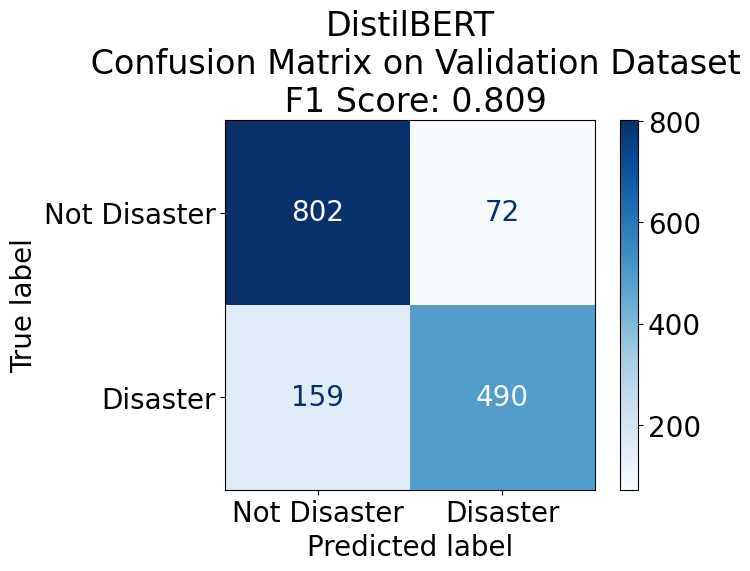

<Figure size 1000x1000 with 0 Axes>

In [93]:
#Валидация
y_pred_val = classifier.predict(X_val)

displayConfusionMatrix(y_val, y_pred_val, "Validation")

print("CatBoostClassifier (Word2Vec)")
print(cm_w2v)
print('f1='+str(f1_cat.round(3)))
print("LogisticRegression (TFIDF)")
print(cm2)
print('f1='+str(f1_lr_tfidf.round(3)))
print("LogisticRegression (Bag of Words)")
print(cm)
print('f1='+str(f1_lr_bow.round(3)))